In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import pickle
import gzip
from tqdm import tqdm_notebook, tqdm
import tensorflow as tf
import keras.backend as K

%matplotlib inline

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
K.set_session(sess)

# Reading dataset

In [4]:
with gzip.open('../cache/dataset.pkl.gz', 'rb') as f:
    X_raw, y_raw = pickle.load(f)

In [5]:
len(X_raw), len(y_raw)

(17, 17)

In [6]:
X_holdout, y_holdout = X_raw[10], y_raw[10] # lavina

In [7]:
X_raw = X_raw[:10] + X_raw[11:]
y_raw = y_raw[:10] + y_raw[11:]

In [8]:
len(X_holdout)

769

In [9]:
pd.Series.value_counts(y_holdout)

2    593
0    145
1     31
dtype: int64

In [10]:
X = []
y = []

for x in X_raw:
    X.extend(x)

for y_ in y_raw:
    y.extend(y_)

In [11]:
len(X), len(y)

(18507, 18507)

# Feature extratction

In [13]:
from scipy.fftpack import fft
from scipy import signal

In [14]:
sample_rate = 22050

In [15]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [16]:
X = [x if type(x) == type(np.array([])) else np.array(x) for x in X]

In [17]:
X_holdout = [x if type(x) == type(np.array([])) else np.array(x) for x in X_holdout]

In [18]:
len(X)

18507

In [19]:
pd.Series.value_counts([len(x) for x in X])

6615    18506
6318        1
dtype: int64

In [20]:
bad_ind = (np.array([len(x) == 6318 for x in X])).nonzero()[0][0]

In [21]:
bad_ind

1779

In [22]:
X = X[:bad_ind] + X[bad_ind + 1:]
y = y[:bad_ind] + y[bad_ind + 1:]

In [23]:
pd.Series.value_counts([len(x) for x in X])

6615    18506
dtype: int64

In [24]:
def extract_features(x, lim=100, for_cnn=True):
    _, _, spec = log_specgram(x, sample_rate)
    spec = spec[:, :lim]
    if for_cnn:
        spec = np.expand_dims(spec, -1)
    return spec

In [25]:
len(X)

18506

In [54]:
X_spec = []
for x in tqdm(X):
    spec = extract_features(x)
    X_spec.append(spec)
X_spec = np.array(X_spec)

100%|██████████| 18506/18506 [00:11<00:00, 1648.07it/s]


In [55]:
X_spec.shape

(18506, 28, 100, 1)

In [56]:
X_holdout_spec = []
for x in tqdm(X_holdout):
    spec = extract_features(x)
    X_holdout_spec.append(spec)
X_holdout_spec = np.array(X_holdout_spec)

100%|██████████| 769/769 [00:00<00:00, 1669.78it/s]


# Data split

In [57]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [58]:
X_spec.shape

(18506, 28, 100, 1)

In [59]:
X_spec.mean()

-20.350365

In [60]:
X_spec.std()

2.89434

In [61]:
mean = X_spec.mean()
std = X_spec.std()

In [62]:
X_spec -= mean
X_spec /= std

In [63]:
X_spec.mean(), X_spec.std()

(-1.1548994e-05, 0.99999994)

In [64]:
X_val, y_val = X_holdout_spec, y_holdout

In [65]:
X_val -= mean
X_val /= std

In [66]:
X_val.mean(), X_val.std()

(0.35131416, 1.047145)

In [67]:
y_cat = to_categorical(y)
y_val_cat = to_categorical(y_val)

In [68]:
vc = pd.Series.value_counts(np.argmax(y_cat, 1), True)
vc

2    0.838917
0    0.132011
1    0.029072
dtype: float64

In [69]:
frac = 0.75

In [70]:
vc[2] / vc[0] * frac - 1, vc[2] / vc[1] * frac - 1

(3.766168645108473, 20.642657992565056)

In [71]:
X_spec = np.vstack((X_spec, np.repeat(X_spec[np.argmax(y_cat, 1) == 0], 4, 0)))
y_cat = np.vstack((y_cat, np.repeat(y_cat[np.argmax(y_cat, 1) == 0], 4, 0)))

X_spec = np.vstack((X_spec, np.repeat(X_spec[np.argmax(y_cat, 1) == 1], 20, 0)))
y_cat = np.vstack((y_cat, np.repeat(y_cat[np.argmax(y_cat, 1) == 1], 20, 0)))

In [72]:
pd.Series.value_counts(np.argmax(y_cat, 1), True)

2    0.397689
0    0.312900
1    0.289410
dtype: float64

---

In [73]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [74]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from keras.layers import GRU, BatchNormalization, Reshape
from keras.utils import to_categorical
from keras.layers import Input, Conv1D, Activation, MaxPool1D
from keras.models import Model

# Cnn model

In [98]:
def create_cnn_model(input_shape):
    x_input = Input(input_shape)
    x = Conv2D(16, 3, activation='relu', padding='same')(x_input)
    x = Conv2D(16, 3, activation='relu', padding='same')(x)
    x = MaxPool2D((2, 3))(x)
    
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPool2D()(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPool2D()(x)
    
    x = Conv2D(128, 3, activation='relu')(x)
    x = Conv2D(128, (1, 6), activation='relu')(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)

    model = Model(inputs=x_input, outputs=x)
    return model

In [99]:
cnn_model = create_cnn_model(X_spec[0].shape)

In [100]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 100, 1)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 100, 16)       160       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 100, 16)       2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 33, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 33, 32)        4640      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 33, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 16, 32)         0         
__________

In [101]:
X_spec[0].shape

(28, 100, 1)

In [102]:
cnn_model.compile('adam', 'categorical_crossentropy')

## Training

In [103]:
# def schedule(i, lr):
#     if i == 0:
#         lr *= 0.5
#     if i == 5:
#         lr *= 0.2
#     if i == 10:
#         lr *= 0.2
#     return lr

In [104]:
def schedule(i, lr):
    if i == 0:
        lr *= 0.3
    if i == 5:
        lr *= 0.1
    if i == 10:
        lr *= 0.2
    return lr

In [105]:
X_spec.shape, y_cat.shape

((39038, 28, 100, 1), (39038, 3))

In [106]:
hist = cnn_model.fit(X_spec, y_cat, batch_size=128, epochs=7,
#                  class_weight={0: 3, 1: 5, 2: 1},
                 validation_data=(X_val, y_val_cat), # val
                 callbacks=[keras.callbacks.LearningRateScheduler(schedule, verbose=1)])

Train on 39038 samples, validate on 769 samples
Epoch 1/7

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0003000000142492354.
39038/39038 [==============================] - 112s 3ms/step - loss: 0.5143 - val_loss: 0.3257
Epoch 2/7

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0003000000142492354.
39038/39038 [==============================] - 110s 3ms/step - loss: 0.2360 - val_loss: 0.4902
Epoch 3/7

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0003000000142492354.
39038/39038 [==============================] - 110s 3ms/step - loss: 0.1583 - val_loss: 0.3167
Epoch 4/7

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0003000000142492354.
39038/39038 [==============================] - 110s 3ms/step - loss: 0.1153 - val_loss: 0.2683
Epoch 5/7

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0003000000142492354.
39038/39038 [==============================] - 110s 3ms/step - loss: 0.0922 - val_loss: 0.3566
Ep

In [107]:
pr = cnn_model.predict(X_val, batch_size=128, verbose=1)

769/769 [==============================] - 1s 863us/step


In [108]:
pr = pr.argmax(1)

In [109]:
pd.Series.value_counts(pr)

2    567
0    169
1     33
dtype: int64

In [111]:
accuracy_score(np.argmax(y_val_cat, 1), pr)

0.929778933680104

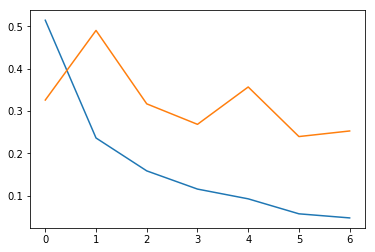

In [112]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')

In [113]:
print(classification_report(np.argmax(y_val_cat, 1), pr))

             precision    recall  f1-score   support

          0       0.80      0.94      0.87       145
          1       0.76      0.81      0.78        31
          2       0.98      0.93      0.96       593

avg / total       0.94      0.93      0.93       769



---

In [115]:
%timeit cnn_model.predict(X_val[:1, :, :])

2.01 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Saving

In [116]:
cnn_model.save('../cache/cnn_model.h5')

In [117]:
cnn_model_json = cnn_model.to_json()

In [118]:
with open('../cache/cnn_model.json', 'w') as f:
    f.write(cnn_model_json)

In [119]:
cnn_model.save_weights('../cache/cnn_model_weights.h5')

# Testing

In [121]:
test_audio, sr = librosa.load('../audio/diplom.m4a')

In [122]:
interval_time = 0.3
interval_step = 0.1

interval_len, step_len = librosa.time_to_samples(interval_time), \
                 librosa.time_to_samples(interval_step) #[0]

In [123]:
interval_len, step_len

(6615, 2205)

In [124]:
len(test_audio)

20231647

In [125]:
min_delta = interval_len // 3

In [126]:
min_delta

2205

In [127]:
def get_audio_intervals(audio):
    return [(x, x + interval_len) for x in range(0, len(audio), step_len)][:-4]

In [128]:
%%time
test_intervals = get_audio_intervals(test_audio)

CPU times: user 6.81 ms, sys: 0 ns, total: 6.81 ms
Wall time: 6.78 ms


In [129]:
len(test_intervals)

9172

In [130]:
test_samples = [test_audio[s:f] for s, f in test_intervals]

In [131]:
test_features = np.stack([extract_features(x) for x in tqdm(test_samples)])

100%|██████████| 9172/9172 [00:05<00:00, 1561.87it/s]


In [132]:
test_features.shape

(9172, 28, 100, 1)

TODO: нормальная нормальзация

In [133]:
test_features -= mean
test_features /= std

In [134]:
test_predict_cnn = cnn_model.predict(test_features, batch_size=128).argmax(1)

In [138]:
test_predict_pr = cnn_model.predict(test_features, batch_size=128)

In [135]:
pd.Series.value_counts(test_predict_cnn)

2    8259
0     851
1      62
dtype: int64

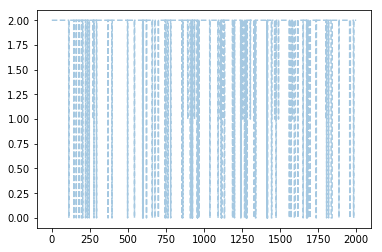

In [137]:
plt.plot(test_predict_cnn[:2000], '--', label='pr', alpha=0.4)

## Sliding window

In [140]:
test_predict_mean = np.stack(((np.pad(test_predict_pr[1:, 0], (0, 1), 'edge') + \
                    test_predict_pr[:, 0] + \
    np.pad(test_predict_pr[:-1, 0], (1, 0), 'edge')) / 3,
          (np.pad(test_predict_pr[1:, 1], (0, 1), 'edge') + test_predict_pr[:, 1] + \
    np.pad(test_predict_pr[:-1, 1], (1, 0), 'edge')) / 3,
          (np.pad(test_predict_pr[1:, 2], (0, 1), 'edge') + test_predict_pr[:, 2] + \
    np.pad(test_predict_pr[:-1, 2], (1, 0), 'edge')) / 3), axis=1)

In [141]:
test_predict_mean.shape

(9172, 3)

In [147]:
lim = 500

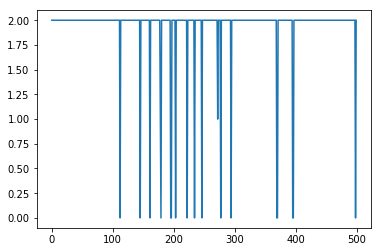

In [148]:
plt.plot(test_predict_cnn[:lim])

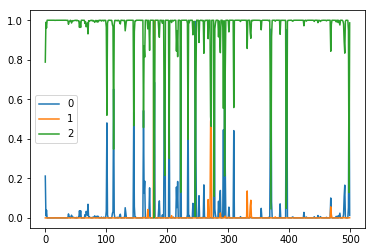

In [149]:
plt.plot(test_predict_pr[:lim, 0], label='0')
plt.plot(test_predict_pr[:lim, 1], label='1')
plt.plot(test_predict_pr[:lim, 2], label='2')
plt.legend()

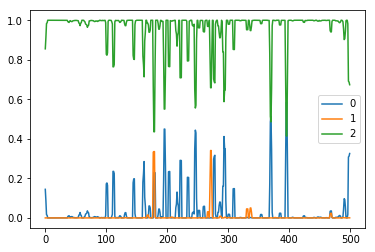

In [150]:
plt.plot(test_predict_mean[:lim, 0], label='0')
plt.plot(test_predict_mean[:lim, 1], label='1')
plt.plot(test_predict_mean[:lim, 2], label='2')
plt.legend()

In [151]:
test_predict_mean[:, 2]

array([0.8554082 , 0.9129645 , 0.98355436, ..., 0.99081963, 0.9925699 ,
       0.9925898 ], dtype=float32)

In [152]:
test_predict_pr[:, 2]

array([0.78823054, 0.9897635 , 0.96089953, ..., 0.99237883, 0.9928924 ,
       0.9924385 ], dtype=float32)

## Отображение результата

In [160]:
from PIL import Image
import os
import shutil

In [161]:
# os.rmdir('../cache/imgs/')
shutil.rmtree('../cache/imgs/')

In [162]:
os.mkdir('../cache/imgs')

In [163]:
1 / interval_step

10.0

In [164]:
interval_step

0.1

In [165]:
for i, r in enumerate(test_predict_pr.argmax(1)): # test_predict_mean
    im_r = np.zeros((32, 64, 3), dtype='uint8')
    if r == 0:
        im_r[:,:,0] = 255
    elif r == 2:
        im_r[...,2] = 255
    else:
        im_r[...,1] = 255
            
    im = Image.fromarray(im_r)
    im.save('../cache/imgs/test_{:04d}.png'.format(i + 2))
im.save('../cache/imgs/test_{:04d}.png'.format(0))
im.save('../cache/imgs/test_{:04d}.png'.format(1))

In [166]:
os.system('ffmpeg -r 10 -i ../cache/imgs/test_%04d.png -i ../audio/diplom.m4a -vcodec mpeg4 -y ../cache/diplom_pr.mp4')

0

## Ручная корректировка шума

In [167]:
test_predict_new = test_predict_cnn.ravel()

In [ ]:
%%time
test_predict_new2 = []

start = False
for t, tn in zip(test_predict_new, np.append(test_predict_new[1:], [1])):
    if t == 0 and tn == 0 and not start:
        # если встретили 0 и следующий 0 и до этого не началось, включаем начало и доб-ем 0
        start = True
        test_predict_new2.append(0)
    elif t == 0 and tn == 0 and start:
        # если встретили 0 и следующий 0 и до этого началось, доб-ем 0 - мы в серии нулей
        test_predict_new2.append(0)
    elif t == 0 and tn != 0 and not start:
        # если встретили 0, а следующий не 0 и до этого не началось, значит шум, не 0 
        test_predict_new2.append(1)
    elif t == 0 and tn != 0 and start:
        # если встретили 0, а след. не 0 и до этого началось, значит 0, но начало в False
        start = False
        test_predict_new2.append(0)
    elif t == 1:
        # если встрили 1, добавляем 1
        test_predict_new2.append(1)
        start = False
    else:
        print(t, tn, start)

In [ ]:
pd.Series.value_counts(test_predict_new)

In [ ]:
pd.Series.value_counts(test_predict_new2)

In [ ]:
print(classification_report(test_data.values, test_predict_new))

In [ ]:
print(classification_report(test_data.values, test_predict_new2))

Precision поднялся на 0.07, а recall упал лишь на 0.01

## Отображение результата

In [ ]:
shutil.rmtree('../cache/imgs/')

In [ ]:
os.mkdir('../cache/imgs')

In [ ]:
for i, (r, t) in enumerate(zip(test_predict_new2, test_data.values)):
    im_r = np.zeros((32, 64, 3), dtype='uint8')
    if r == 0:
        im_r[:,:,0] = 255
    elif r == 1:
        im_r[...,2] = 255
    else:
        im_r[...,1] = 255
        
    im_t = np.zeros((32, 64, 3), dtype='uint8')
    if t == 0:
        im_t[:,:,0] = 255
    elif t == 1:
        im_t[...,2] = 255
    else:
        im_t[...,1] = 255
        
    im = np.vstack((im_r, im_t))
    im = Image.fromarray(im)
    im.save('../cache/imgs/test_{:04d}.png'.format(i + 2))
im.save('../cache/imgs/test_{:04d}.png'.format(0))
im.save('../cache/imgs/test_{:04d}.png'.format(1))

In [ ]:
os.system('ffmpeg -r 20 -i ../cache/imgs/test_%04d.png -i ../audio/arhis1.mp3 -vcodec mpeg4 -y ../cache/aa.mp4')